In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [ ]:
params_dict = {
    "population": {
        "simulation_repetition": 1,
        "grid_size": 15,
        "accessibility": 0.7,
        "time_steps": 75000
    },
    "agent": {
        "connectivity": 0.4,
        "learning_rate": 0.3,
        "confidence_threshold": 0.5,
        "tolerance": 0.05,

    }
}

In [ ]:
class Params:
    def __init__(self):
        self._population_config = params_dict["population"]
        self._agent_config = params_dict["agent"]

    def get_population_parameter(self, parameter_name):
        if parameter_name not in self._population_config:
            return None
        return self._population_config[parameter_name]

    def get_agent_parameter(self, parameter_name):
        if parameter_name not in self._agent_config:
            return None
        return self._agent_config[parameter_name]


parameters = Params()

In [ ]:
class Cell:
    """ Each cell in the population grid """
    def __init__(self, op, pos, grid_size):
        self.op = op
        self.posx = pos[0]
        self.posy = pos[1]
        self.grid_size = grid_size
        self.agent_type = "disconnected"
        self.communication_status = "offline"


    def getNeighbors(self):
        row, col = self.posx, self.posy
        shifts = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        neighbors = []
        for dr, dc in shifts:
            nr = (row + dr) % self.grid_size
            nc = (col + dc) % self.grid_size
            neighbors.append((nr, nc))
        return neighbors

    def set_communication_status(self):
        self.communication_status = "offline" if self.agent_type == "disconnected" else random.choice(["offline", "online"])

    def change_agent_type(self, type = "connected"):
        self.agent_type = type
        self.set_communication_status()


In [ ]:
class ExtendedBCMmodel:
    def __init__(self, parameters : Params, Cell ):
        self.grid_size = parameters.get_population_parameter("grid_size")
        self.accessibility = parameters.get_population_parameter("accessibility")
        self.learning_rate = parameters.get_agent_parameter("learning_rate")
        self.confidence_threshold = parameters.get_agent_parameter("confidence_threshold")
        self.tolerance = parameters.get_agent_parameter("tolerance")
        self.connectivity = parameters.get_agent_parameter("connectivity")
        self.time_steps = parameters.get_population_parameter("time_steps")
        self._grid = None

        self.populate_grid()

        self.population_size = self.grid_size * self.grid_size
        self.num_ConnectedAgents = int(self.grid_size * self.accessibility)
        self.num_DiffusionAtOnce = self.num_ConnectedAgents * self.connectivity
        self.all_Agents = None
        self.ConnectedAgents = None # a list of positions(tuple) of all connected agents
        self.DisconnectedAgents = None

        self._initialize_Agents()

        self.grid_op = None
        self.grid_opinion_over_time = {t : None for t in range(int(self.time_steps))}  # every key holds 2d array(grid) of opinions at that time step
        self.opinion_of_agents_over_time = None                                            # A list where every element refers to each agent containing its opinion for every time step


    def _create_grid(self):
        self._grid = np.zeros([self.grid_size,self.grid_size], dtype=Cell)

    def populate_grid(self):

        if self._grid is None:
            self._create_grid()

        for pos, value in np.ndenumerate(self._grid):
            self._grid[pos] = Cell(round(random.uniform(0, 1), 2), pos, self.grid_size)


    def _initialize_Agents(self):

        # an agent is initialized randomly as connected owing to constraint "num_connectedagents"
        self.all_Agents = [(i,j) for i in range(self.grid_size) for j in range(self.grid_size)]
        self.ConnectedAgents = random.choices(self.all_Agents, k = self.num_ConnectedAgents)


        for pos in self.ConnectedAgents:
            self._grid[pos].change_agent_type(type = "connected")

        self.DisconnectedAgents = list(set(self.all_Agents) - set(self.ConnectedAgents))


    def visualization(self):

        if self._grid is None:
            self.populate_grid()

        self.get_agent_opinions()


        plt.clf()
        plt.imshow(self.grid_op, origin='lower')
        plt.show()

    def _diffuse_opinion(self, cell, number_diffusionAtOnce):

                x1 = cell.op

                ConnectedAgents_of_cell = random.choices(self.ConnectedAgents, k = int(number_diffusionAtOnce))
                for pos in ConnectedAgents_of_cell:
                     x2 = self._grid[pos].op
                     x2_new = x2 + self.learning_rate * (x1 - x2)

                     self._grid[pos].op = round(x2_new, 2)

    def _exchange_opinion(self, cell1, cell2):
            x1 = cell1.op
            x2 = cell2.op

            if (abs(x1 - x2) < self.confidence_threshold - self.tolerance * 2):
                x1_new = x1 + self.learning_rate * (x2 - x1)
                x2_new = x2 + self.learning_rate * (x1 - x2)
                cell1.op = round(x1_new, 2)
                cell2.op = round(x2_new, 2)

            # Negative Influence:
            elif (abs(x1 - x2) > self.confidence_threshold + self.tolerance * 2):
                if (x1 > x2):
                    x1_new = (x1 + self.learning_rate * (x1 - x2) * (1 - x1))
                    x2_new = (x2 + self.learning_rate * (x2 - x1) * x2)
                    cell1.op = round(x1_new, 2)
                    cell2.op = round(x2_new, 2)
                else:
                    x1_new = (x1 + self.learning_rate * (x1 - x2) * x1)
                    x2_new = (x2 + self.learning_rate * (x2 - x1) * (1 - x2))
                    cell1.op = round(x1_new, 2)
                    cell2.op = round(x2_new, 2)




    def evolution(self):
        for t in range(self.time_steps):

            cell1_pos = random.choice(self.all_Agents)
            cell1 = self._grid[tuple(cell1_pos)]

            if cell1.agent_type == "connected":
                if cell1.communication_status == "online":
                    ## TODO - implement diffuse_opinion
                    self._diffuse_opinion(cell1, self.num_DiffusionAtOnce)

                else :
                    cell1_neighbors = cell1.getNeighbors()
                    neighbors_len = len(cell1_neighbors)

                    cell2_pos = cell1_neighbors[np.random.randint(neighbors_len)]
                    cell2 = self._grid[cell2_pos]


                    self._exchange_opinion(cell1, cell2)
            elif cell1.agent_type == "disconnected":
                    cell1_neighbors = cell1.getNeighbors()    # in paper they are taking random agent for offline communication, we have taken only neighbour
                    neighbors_len = len(cell1_neighbors)

                    cell2_pos = cell1_neighbors[np.random.randint(neighbors_len)]
                    cell2 = self._grid[cell2_pos]


                    self._exchange_opinion(cell1, cell2)

            self.get_agent_opinions()
            self.grid_opinion_over_time[t] = self.grid_op.copy()


    def get_agent_opinions(self):

        if self.grid_op is None:
            self.grid_op = np.zeros([self.grid_size,self.grid_size])


        for pos, _ in np.ndenumerate(self.grid_op):
            self.grid_op[pos] = self._grid[pos].op

        return self.grid_op

    def plot_opinions_over_time(self, save = True):
        time = list(self.grid_opinion_over_time.keys())
        opinions = list(self.grid_opinion_over_time.values())

        opinions = [ op.flatten() for op in opinions]

        num_agents = len(opinions[0])
        self.opinion_of_agents_over_time = [[opinions[t][pos] for t in time] for pos in range(num_agents)]

        plt.figure(figsize=(30, 20))

        for agent in range(self.population_size):
            plt.plot(time, self.opinion_of_agents_over_time[agent])


        plt.title('op over time')
        plt.xlabel('time')
        plt.ylabel('opinions ')

        plt.title(f'GridSize: {self.grid_size}, Accessibility: {self.accessibility}, Connectivity : {self.connectivity}, TimeSteps: {self.time_steps}, HHI: {self.metrics()}' , fontsize=14)
        if save == True:
            plt.savefig(r"../results/grid_{}_A_{}_C_{}_time_{}_HHI_{}.png".format(self.grid_size, self.accessibility, self.connectivity, self.time_steps, self.metrics() ))
        plt.show()

    def get_clusters(self):

        import collections

        lastevolutions_opinions = list(self.grid_opinion_over_time[len(self.grid_opinion_over_time )-1].flatten())

        count_lastevolutions_opinions = collections.Counter(lastevolutions_opinions)

        return count_lastevolutions_opinions

    def metrics(self):

        cluster_dict = self.get_clusters()

        cluster_sizes = list(cluster_dict.values())
        cluster_sizes = [i for i in cluster_sizes if i>5]  # >5 agents forms a cluster, this is an assumption

        hhi = sum([(i/self.population_size)**2 for i in cluster_sizes])

        return np.round(hhi, 3)


    def print_metrics(self):

        hhi = self.metrics()

        print("#"*10 + "    METRICS     " + "#"*10)
        print("\n")
        print("HHI" + "     ===>  ", hhi)
        print("\n")
        print("#"*38)



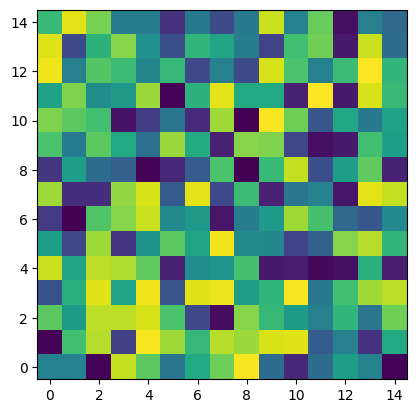

In [ ]:
bcm = ExtendedBCMmodel(parameters, Cell)
bcm.visualization()

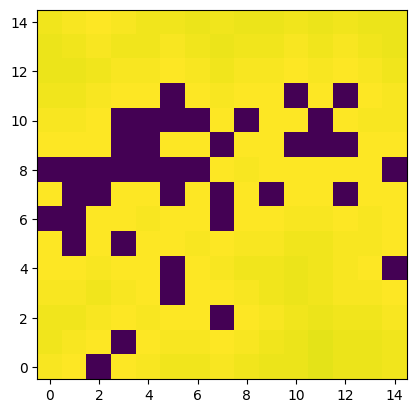

In [ ]:
bcm.evolution()
bcm.visualization()

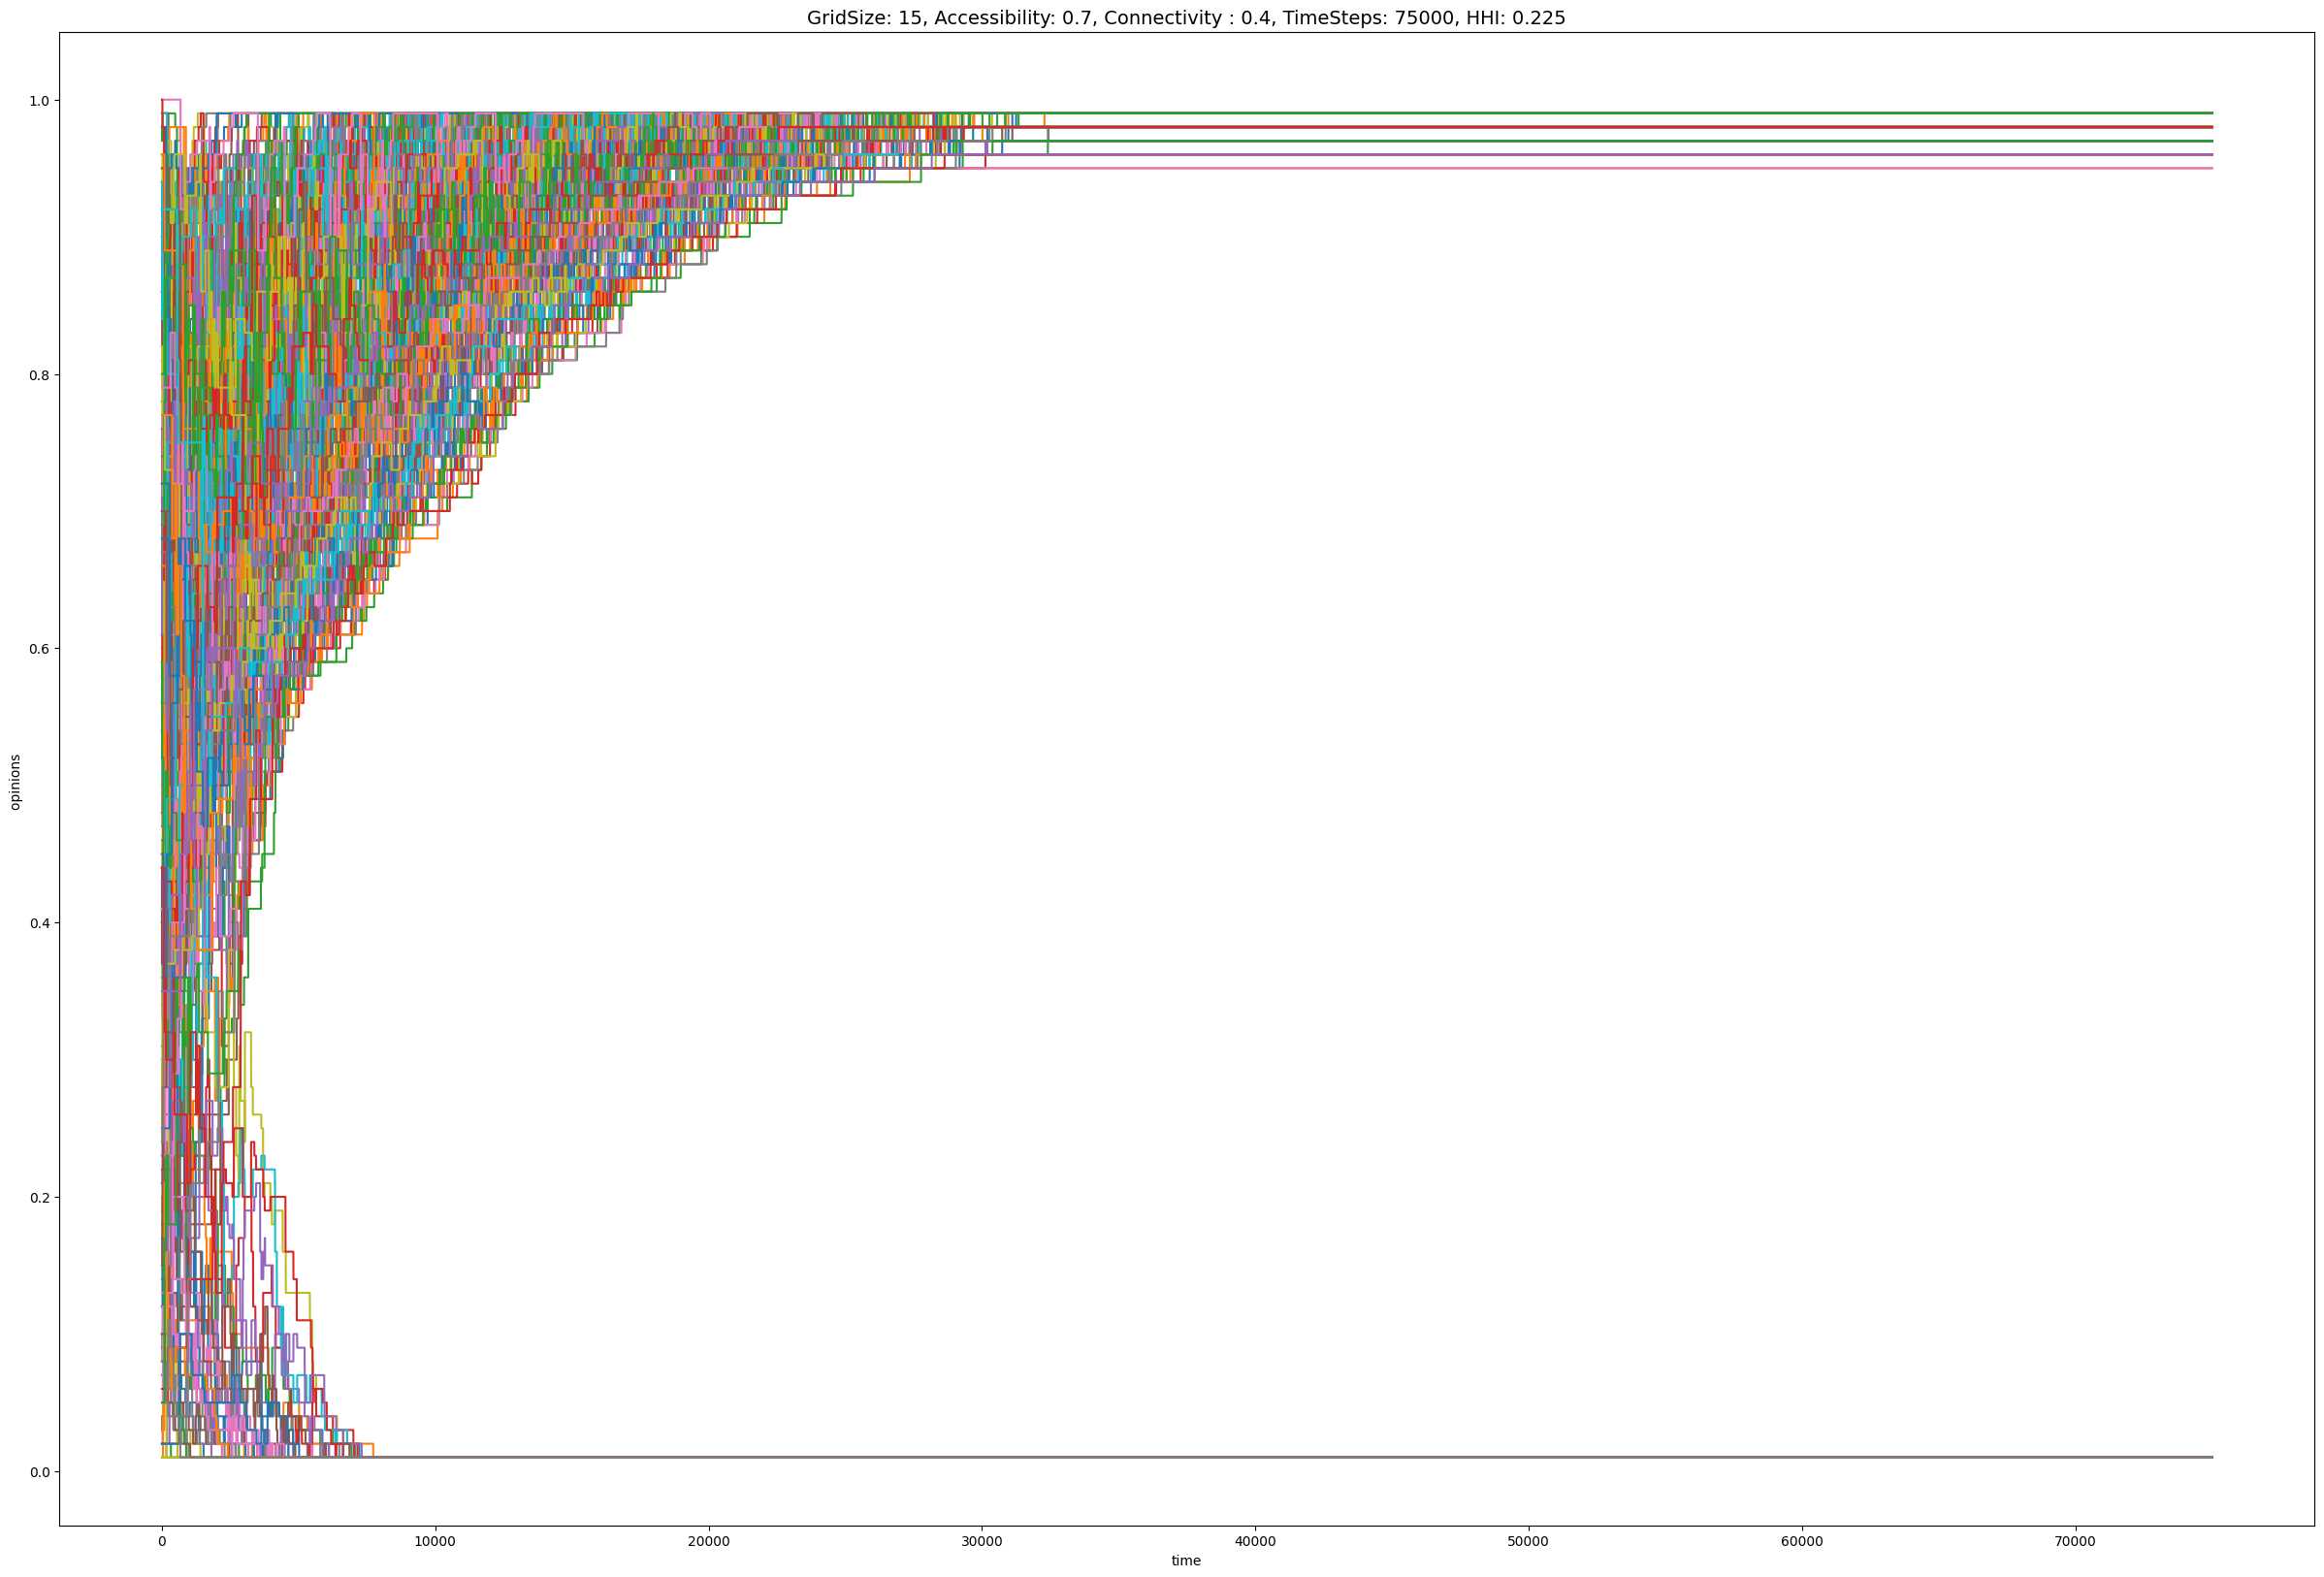

In [ ]:
bcm.plot_opinions_over_time()

In [ ]:
bcm.print_metrics()

##########    METRICS     ##########


HHI     ===>   0.225


######################################
